In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


House (individual) measurements of radon activity

In [2]:
rename_dict = {}
data = pd.read_csv("ARM_DATA/radon/srrs2.dat")
for col in data.columns:
    rename_dict[col] = col.strip()

data = data.rename(rename_dict, axis=1)
data["county"] = data["county"].str.strip()

Radon Measure at the county (group) level

In [3]:
uranium = pd.read_csv("ARM_DATA/radon/cty.dat")
for col in data.columns:
    rename_dict[col] = col.strip()
uranium = uranium.rename(rename_dict, axis=1)
uranium["county"] = uranium["cty"].str.strip()

Consider only Minnesota, then average the uranium measurements in a county and give each individual measurement that county uranium level

In [4]:
data = data[data["state"] == "MN"]
uranium = uranium[uranium["st"] == "MN"]

uranium = uranium.groupby(["ctfips","county"]).mean()["Uppm"].reset_index()
uranium = uranium[uranium["ctfips"].isin(data["cntyfips"])]
data = data.merge(uranium[["ctfips","Uppm"]], how="inner", left_on="cntyfips", right_on="ctfips")

Radon levels, floor of house indicator, and county level radon assigned to each house.

In [5]:
y = np.log(data["activity"].to_numpy() + 0.1)
x = data["floor"].to_numpy()
u = np.log(data["Uppm"].to_numpy())

In [6]:
county_encoder = LabelEncoder()
counties = county_encoder.fit_transform(data["cntyfips"].to_numpy())

no_counties = len(county_encoder.classes_)

county_observations = data.groupby(["cntyfips"]).count()["idnum"].reset_index()
county_observations = county_observations["idnum"].to_numpy()

# count, county_name = pd.factorize(data["county"])
# for i, name in enumerate(county_name):
#     print(i, name, county_observations[i])

## Complete Pooling
collapse all County Level information

There is one intercept that accounts for all counties as one

Effectively, sigma_alpha -> 0

In [7]:
with pm.Model() as model_complete_pooling:

    alpha = pm.Normal("alpha", 0, 1)

    beta = pm.Normal("beta", 0, 1)
    sigma = pm.Exponential("sigma", 1)

    resp = alpha + beta * x

    obs = pm.Normal("obs", mu=resp, sd=sigma, observed=y)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_81063/4156022615.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_complete_pooling = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.war

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


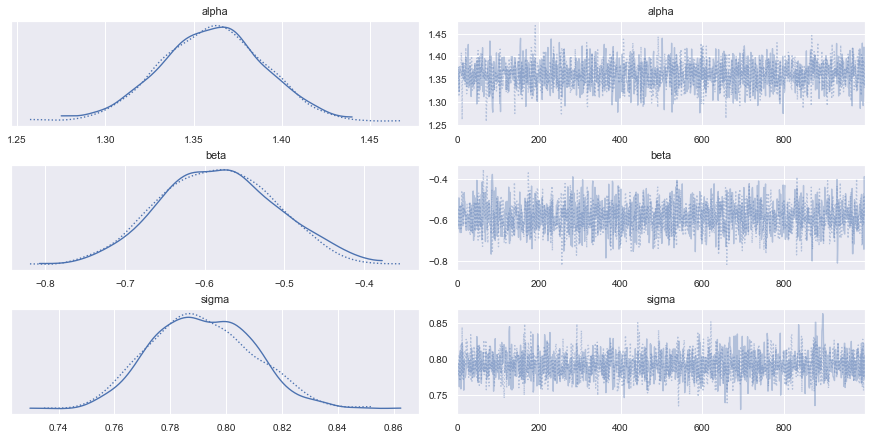

In [8]:
with model_complete_pooling:
    trace_complete_pooling = pm.sample()
    pm.plot_trace(trace_complete_pooling)

## No Pooling
Every county gets its own independent predictor

Effectively, sigma_alpha -> infinity

y = county + floor * x

In [9]:
with pm.Model() as model_no_pooling:

    beta = pm.Normal("beta", mu=0, sigma=1)
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=no_counties)

    resp = alpha[counties] + beta * x

    sigma = pm.Exponential("sigma", 1)

    obs = pm.Normal("obs", mu = resp, sigma = sigma, observed=y)
    

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_81063/428881173.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_no_pooling = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, beta]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


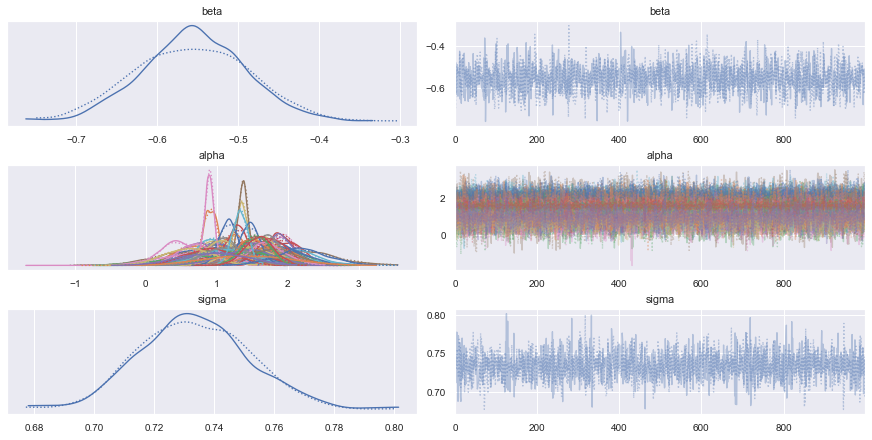

In [10]:
with model_no_pooling:
    trace_no_pooling = pm.sample()
    pm.plot_trace(trace_no_pooling)

## Pooled Model

mu_alpha ~ N(0, 100)

sigma_alpha ~ Gamma(3,2)

county ~ N(mu_alpha, sigma_alpha)

floor ~ N(0, 10)

### Pooled Intercept Only varying by county

In [11]:
with pm.Model() as model_pooled_counties:

    gamma_0 = pm.Normal("gamma_0", mu=0, sigma=10)
    sigma_alpha = pm.Gamma("sigma_alpha", mu=3, sigma=2)
    
    alpha = pm.Normal("alpha", mu=gamma_0, sigma=sigma_alpha, shape=no_counties)
    
    resp = alpha[counties]

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_81063/2921781156.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pooled_counties = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, alpha, sigma_alpha, gamma_0]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeErro

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


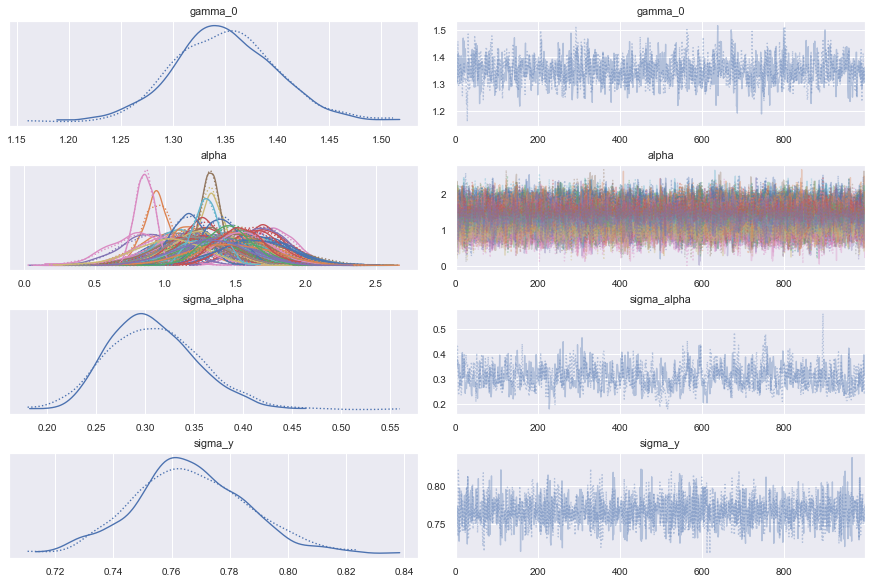

In [12]:
with model_pooled_counties:
    trace_pooled_counties = pm.sample()
    pm.plot_trace(trace_pooled_counties)

### Pooled intercept with a floor predictor

In [13]:
with pm.Model() as model_pooled_vary_intercepts:

    gamma_0 = pm.Normal("gamma_0", mu=0, sigma=10)
    sigma_alpha = pm.Gamma("sigma_county", mu=3, sigma=2)
    
    alpha = pm.Normal("alpha", mu=gamma_0, sigma=sigma_alpha, shape=no_counties)
    
    beta = pm.Normal("beta", mu=0, sigma=10)

    resp = alpha[counties] + beta * x

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_81063/514078007.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pooled_vary_intercepts = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, beta, alpha, sigma_county, gamma_0]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in 

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.


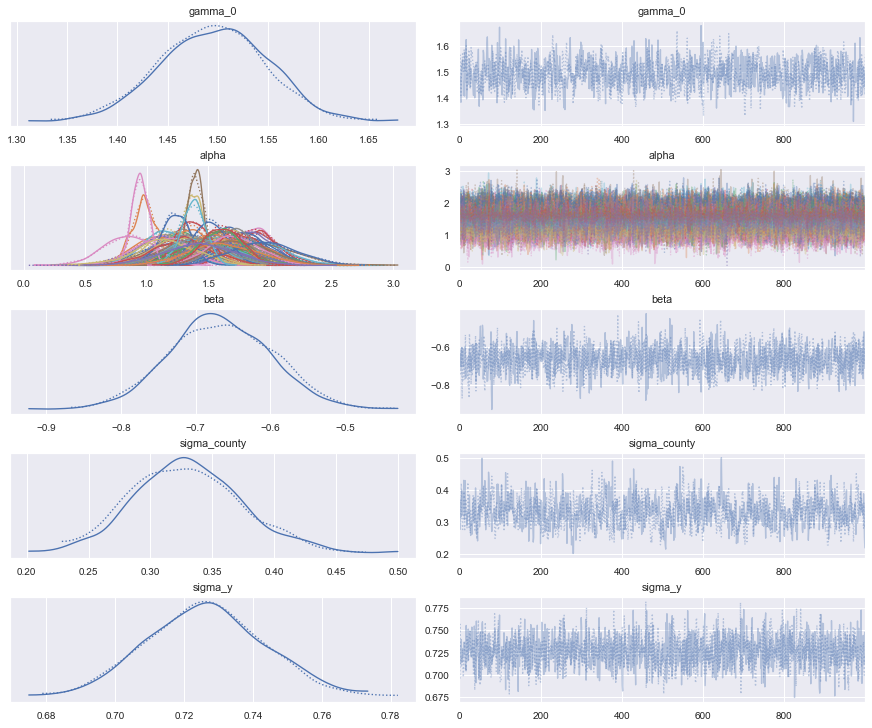

In [14]:
with model_pooled_vary_intercepts:
    trace_pooled_vary_intercepts = pm.sample()
    pm.plot_trace(trace_pooled_vary_intercepts)

Collect the means from the sampling of the model with no pooling (each county gets its own estimate) and a pooled estimate.

np.argsort(county_obsevations) gets us the county with fewest observations 

In [15]:
means = []
sds = []
for i in np.argsort(county_observations):
    means.append(np.mean(trace_no_pooling["alpha"][:,i]))
    sds.append(np.std(trace_no_pooling["alpha"][:,i]))

mean_no_pooled = np.array(means)
sd_no_pooled = np.array(sds)

means = []
sds = []
for i in np.argsort(county_observations):
    means.append(np.mean(trace_pooled_vary_intercepts["alpha"][:,i]))
    sds.append(np.std(trace_pooled_vary_intercepts["alpha"][:,i]))

mean_pooled = np.array(means)
sd_pooled = np.array(sds)

x_axis = np.array([i for i in range(no_counties)])

Uncertainty reduction about the pooled model

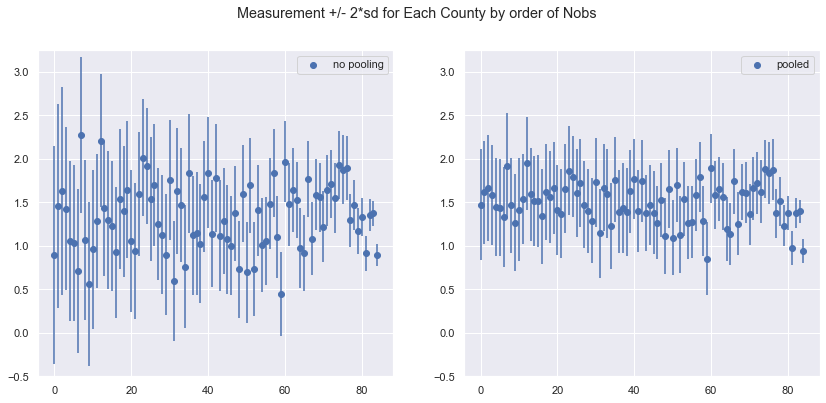

In [16]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[1].vlines(x=x_axis, ymin=mean_pooled-2*sd_pooled, ymax=mean_pooled+2*sd_pooled)
ax[1].scatter(x_axis, mean_pooled, label="pooled")
ax[1].axis(ymin=-0.5, ymax=3.25)
ax[1].legend()
ax[0].vlines(x=x_axis, ymin=mean_no_pooled-2*sd_no_pooled, ymax=mean_no_pooled+2*sd_no_pooled)
ax[0].scatter(x_axis, mean_no_pooled, label="no pooling")
ax[0].axis(ymin=-0.5, ymax=3.25)
ax[0].legend()
fig.suptitle("Measurement +/- 2*sd for Each County by order of Nobs")
plt.show()

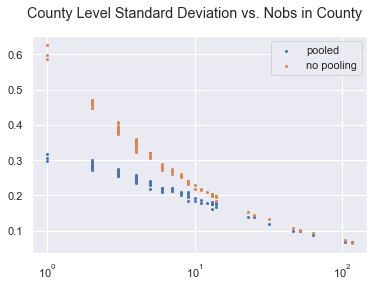

In [17]:
fig, ax = plt.subplots()
fig.suptitle("County Level Standard Deviation vs. Nobs in County")

ax.scatter(np.sort(county_observations), sd_pooled, s=4, label="pooled")
ax.scatter(np.sort(county_observations), sd_no_pooled, s=4, label="no pooling")
ax.set_xscale("log")
ax.legend()

### Alpha and Beta are modeled independently

In [18]:
with pm.Model() as model_pooled_vary_intercepts_slope_ind:

    gamma_0 = pm.Normal("gamma_0", mu=0, sigma=10)
    sigma_county = pm.Gamma("sigma_county", mu=3, sigma=2)
    
    alpha = pm.Normal("alpha", mu=gamma_0, sigma=sigma_county, shape=no_counties)
    
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    sigma_floor = pm.Gamma("sigma_floor", mu=3, sigma=2)

    beta = pm.Normal("beta", mu=beta_0, sigma=sigma_floor, shape=no_counties)

    resp = alpha[counties] + beta[counties] * x

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_81063/2491181471.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pooled_vary_intercepts_slope_ind = pm.sample(target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, beta, sigma_floor, beta_0, alpha, sigma_county, gamma_0]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. 

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


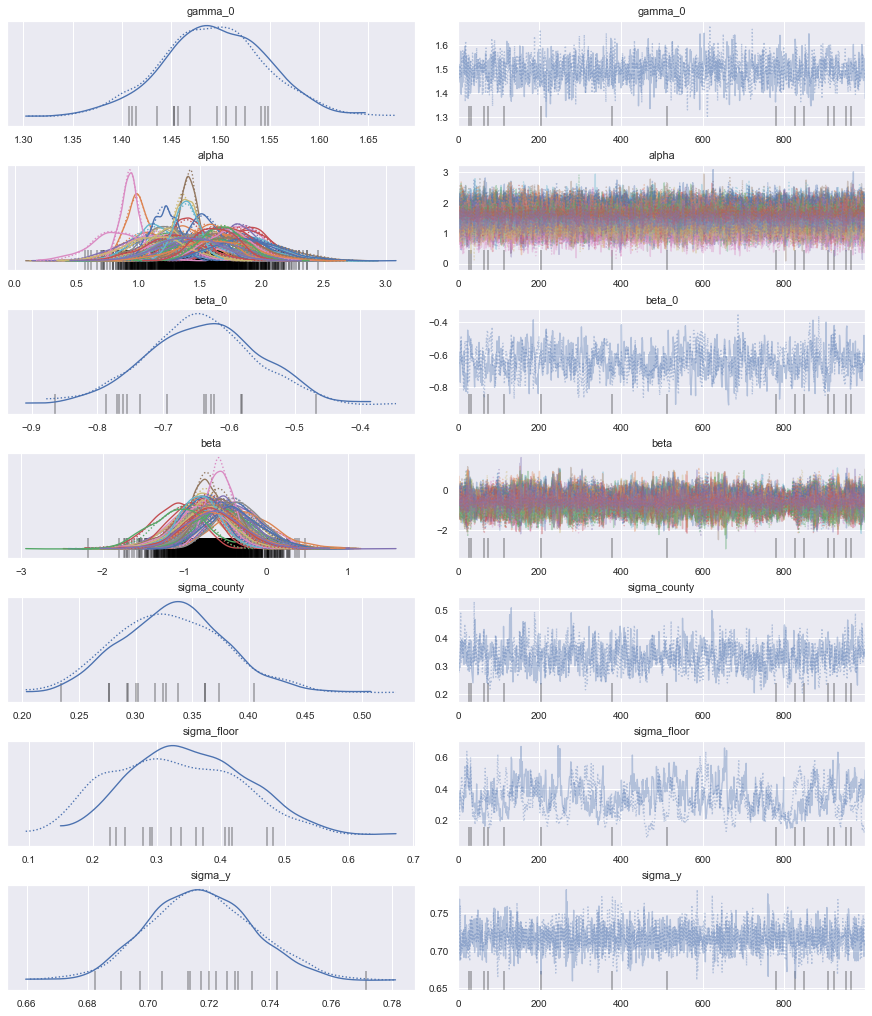

In [19]:
with model_pooled_vary_intercepts_slope_ind:
    trace_pooled_vary_intercepts_slope_ind = pm.sample(target_accept=0.85)
    pm.plot_trace(trace_pooled_vary_intercepts_slope_ind)

### Alpha and Beta are modeled with some covariance between them

In [26]:
import theano.tensor as tt

with pm.Model() as model_pooled_vary_intercepts_slope:

    theta_ = pm.Normal("theta_", mu=0, sigma=10, shape=2)
    sigma_ = pm.Gamma("sigma_", mu=3, sigma=2, shape=2)
    C_triu = pm.LKJCorr('C_triu', n=2, eta=1)

    C = tt.fill_diagonal(C_triu[np.zeros((2,2), 'int')], 1.)

    sigma_diag = tt.nlinalg.diag(sigma_)
    cov = tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag)
    
    ab = pm.MvNormal("ab", mu=theta_, cov=cov, shape=(no_counties, 2))

    alpha = pm.Deterministic("alpha", ab[:,0])
    beta = pm.Deterministic("Beta", ab[:,1])

    resp = alpha[counties] + beta[counties] * x

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

In [20]:
import theano.tensor as tt

with pm.Model() as model_pooled_vary_intercepts_slope:

    alpha_ = pm.Normal("alpha_", mu=0, sigma=10)
    beta_ = pm.Normal("beta_", mu=0, sigma=10)

    sigma_ = pm.Gamma("sigma_", mu=3, sigma=2, shape=2)
    C_triu = pm.LKJCorr('C_triu', n=2, eta=2)
    C = tt.fill_diagonal(C_triu[np.zeros((2,2), 'int')], 1.)

    sigma_diag = tt.nlinalg.diag(sigma_)
    cov = tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag)
    
    ab = pm.MvNormal("ab", mu=tt.stack([alpha_, beta_]), cov=cov, shape=(no_counties, 2))

    alpha = pm.Deterministic("alpha", ab[:,0])
    beta = pm.Deterministic("Beta", ab[:,1])

    resp = alpha[counties] + beta[counties] * x

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_81063/2529219978.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pooled_vary_intercepts_slope = pm.sample(target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, ab, C_triu, sigma_, beta_, alpha_]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma comp

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 306 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


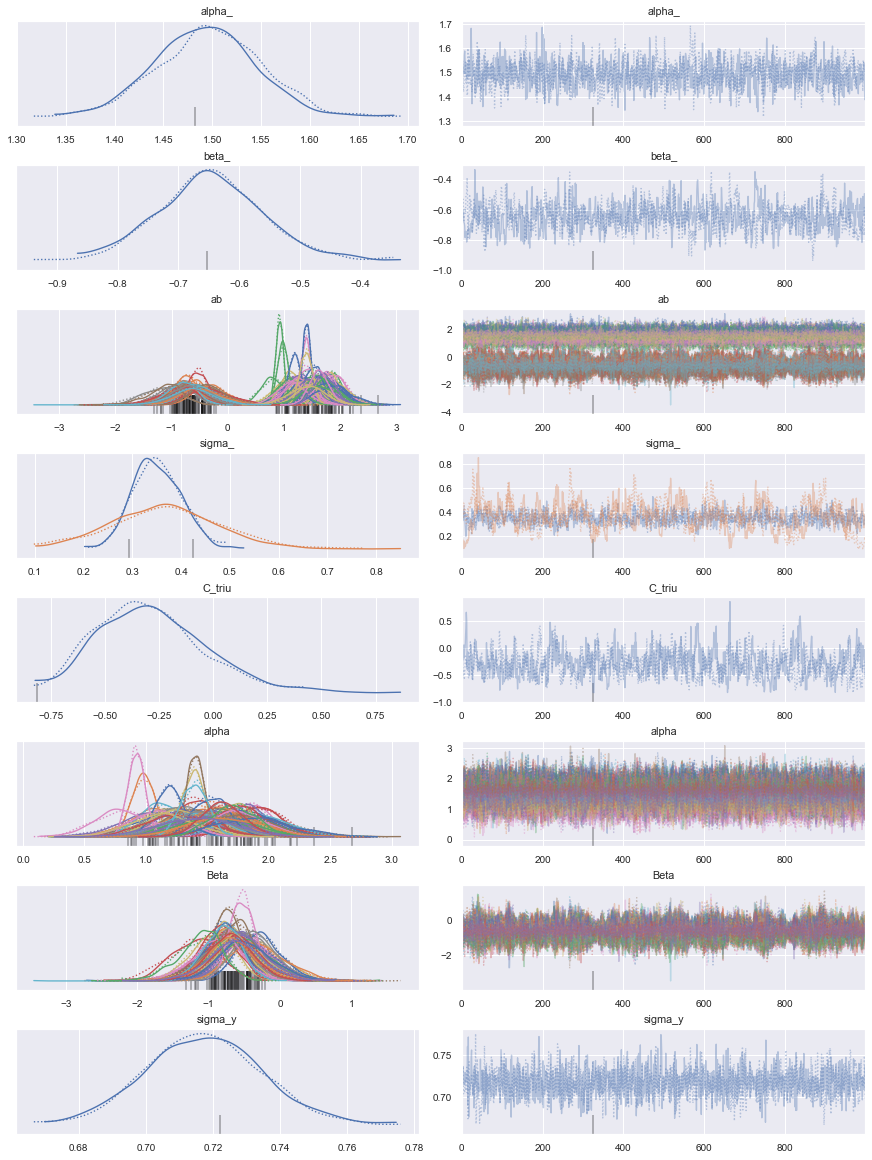

In [21]:
with model_pooled_vary_intercepts_slope:
    trace_pooled_vary_intercepts_slope = pm.sample(target_accept=0.9)
    pm.plot_trace(trace_pooled_vary_intercepts_slope)

In [22]:
means = []
sds = []
for i in np.argsort(county_observations):
    means.append(np.mean(trace_pooled_vary_intercepts_slope["alpha"][:,i]))
    sds.append(np.std(trace_pooled_vary_intercepts_slope["alpha"][:,i]))

mean_pooled_vary_slopes= np.array(means)
sd_pooled_vary_slopes = np.array(sds)

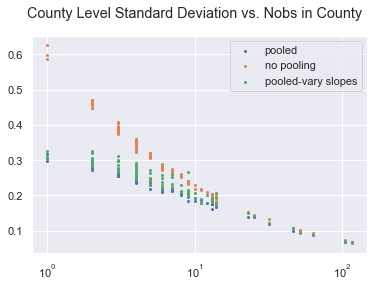

In [24]:
fig, ax = plt.subplots()

fig.suptitle("County Level Standard Deviation vs. Nobs in County")
ax.scatter(np.sort(county_observations), sd_pooled, s=4, label="pooled")
ax.scatter(np.sort(county_observations), sd_no_pooled, s=4, label="no pooling")
ax.scatter(np.sort(county_observations), sd_pooled_vary_slopes, s=4, label="pooled-vary slopes")
ax.set_xscale("log")
ax.legend()

### Add the group level predictor (county) and uranium to model the pooled predictor and then model floors

In [25]:
with pm.Model() as model:

    gamma_0 = pm.Normal("gamma_0", mu=0, sd=10)
    gamma_1 = pm.Normal("gamma_1", mu=0, sd=10)
    sigma_a_ = pm.Exponential("sigma_a_", 1)
    a_error = pm.Normal("a_error", mu=0, sigma=sigma_a_, shape=no_counties)
    mu_ = gamma_0 + gamma_1*u
    alpha = pm.Deterministic("alpha", mu_ + a_error[counties])

    beta = pm.Normal("beta", mu=0, sigma=10)

    resp = alpha + beta * x

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_81063/3585204397.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pooled_uranium = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, beta, a_error, sigma_a_, gamma_1, gamma_0]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in 

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
The acceptance probability does not match the target. It is 0.8902800598723547, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


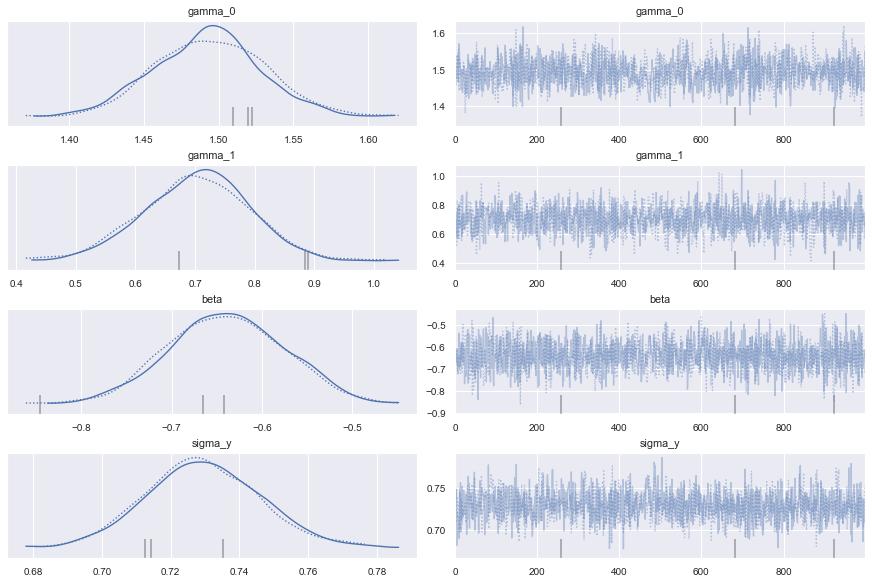

In [26]:
with model:
    trace_pooled_uranium = pm.sample()
    pm.plot_trace(trace_pooled_uranium, var_names=["gamma_0", "gamma_1", "beta", "sigma_y"])

In [27]:
with model:
    gamma_0 = np.median(trace_pooled_uranium["gamma_0"])
    gamma_1 = np.median(trace_pooled_uranium["gamma_1"])
    se = np.std(trace_pooled_uranium["alpha"])

In [28]:
x_ = np.linspace(-1, .7)
y_ = gamma_0 + gamma_1 * x_

In [29]:
first_occurence_of_each_county = [counties.tolist().index(c) for c in np.unique(counties)]
uranium_each_county = u[first_occurence_of_each_county]

Text(0.5, 0.98, 'County Level Estimates vs. Log(Uppm)')

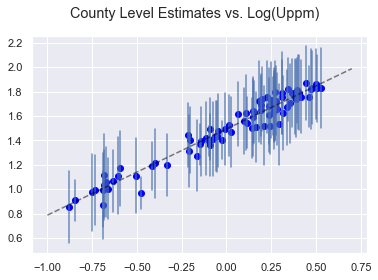

In [30]:
medians_ = np.median(trace_pooled_uranium["alpha"][:,first_occurence_of_each_county],axis=0)
stddevs_ = trace_pooled_uranium["alpha"][:,first_occurence_of_each_county].std(axis=0)

for u_, a_, s_ in zip(uranium_each_county, medians_, stddevs_):
    plt.plot([u_,u_], [a_-2*s_, a_+2*s_], 'b-', alpha=0.8)
    plt.scatter(u_, a_, color="blue", label="county level estimate")

plt.plot(x_, y_, color="black", ls="--", alpha=0.5)
plt.suptitle("County Level Estimates vs. Log(Uppm)")



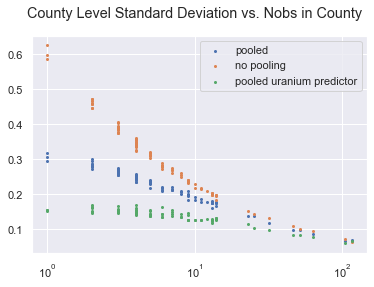

In [31]:
median_county_predictor = medians_[np.argsort(county_observations)]
sd_county_predictor = stddevs_[np.argsort(county_observations)]

fig, ax = plt.subplots()
fig.suptitle("County Level Standard Deviation vs. Nobs in County")
ax.scatter(np.sort(county_observations), sd_pooled, s=4, label="pooled")
ax.scatter(np.sort(county_observations), sd_no_pooled, s=4, label="no pooling")
ax.scatter(np.sort(county_observations), sd_county_predictor, s=4, label="pooled uranium predictor")
ax.set_xscale("log")
ax.legend()



Uncertainty reduction in estimates when group level predictors are added

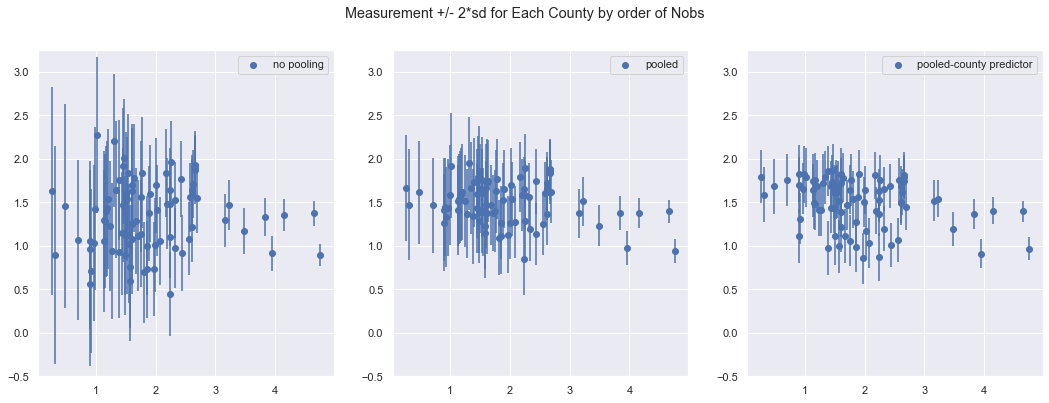

In [32]:
x_jitter = np.abs(np.random.uniform(0, 1, size=len(x_axis)))
x_axis = np.log(np.sort(county_observations) + x_jitter)


fig, ax = plt.subplots(1,3,figsize=(18,6))
fig.suptitle("Measurement +/- 2*sd for Each County by order of Nobs")

ax[0].vlines(x=x_axis, ymin=mean_no_pooled-2*sd_no_pooled, ymax=mean_no_pooled+2*sd_no_pooled)
ax[0].scatter(x_axis, mean_no_pooled, label="no pooling")
ax[0].axis(ymin=-0.5, ymax=3.25)
ax[0].legend()

ax[1].vlines(x=x_axis, ymin=mean_pooled-2*sd_pooled, ymax=mean_pooled+2*sd_pooled)
ax[1].scatter(x_axis, mean_pooled, label="pooled")
ax[1].axis(ymin=-0.5, ymax=3.25)
ax[1].legend()

ax[2].vlines(x=x_axis, ymin=median_county_predictor-2*sd_county_predictor, ymax=median_county_predictor+2*sd_county_predictor)
ax[2].scatter(x_axis, median_county_predictor, label="pooled-county predictor")
ax[2].axis(ymin=-0.5, ymax=3.25)
ax[2].legend()

plt.show()

# Model Comparison

In [40]:
with model_complete_pooling:
    post_pooling = pm.sample_posterior_predictive(trace_complete_pooling, 2000)

with model_no_pooling:
    post_no_pooling = pm.sample_posterior_predictive(trace_no_pooling, 2000)

with model_pooled_counties:
    post_pooled_counties = pm.sample_posterior_predictive(trace_pooled_counties, 2000)

with model_pooled_vary_intercepts:
    post_pooled_vary_intercepts = pm.sample_posterior_predictive(trace_pooled_vary_intercepts, 2000)

with model_pooled_vary_intercepts_slope:
    post_pooled_vary_intercepts_slope = pm.sample_posterior_predictive(trace_pooled_vary_intercepts_slope, 2000)

with model:
    post_pooled_uranium = pm.sample_posterior_predictive(trace_pooled_uranium, 2000)

In [41]:
from sklearn.metrics import mean_squared_error as MSE

In [42]:
print("Complete Pooling:                      {:.5f}".format(MSE(y, post_pooling["obs"].mean(axis=0))))
print("No Pooling:                            {:.5f}".format(MSE(y, post_no_pooling["obs"].mean(axis=0))))
print("Pooled Counties:                       {:.5f}".format(MSE(y, post_pooled_counties["obs"].mean(axis=0))))
print("Pooled Counties w/ Floor Intercept:    {:.5f}".format(MSE(y, post_pooled_vary_intercepts["obs"].mean(axis=0))))
print("Pooled Vary Intercept and Floor Slope: {:.5f}".format(MSE(y, post_pooled_vary_intercepts_slope["obs"].mean(axis=0))))
print("Partial Pooling w/ Group Predictor:    {:.5f}".format(MSE(y, post_pooled_uranium["obs"].mean(axis=0))))

Complete Pooling:                      0.62311
No Pooling:                            0.49128
Pooled Counties:                       0.56031
Pooled Counties w/ Floor Intercept:    0.50017
Pooled Vary Intercept and Floor Slope: 0.47789
Partial Pooling w/ Group Predictor:    0.51866


In [ ]:
import theano.tensor as tt

with pm.Model() as model:

    gamma_0 = pm.Normal("gamma_0", mu=0, sd=10)
    gamma_1 = pm.Normal("gamma_1", mu=0, sd=10)
    # sigma_a_ = pm.Exponential("sigma_a_", 1)
    # a_error = pm.Normal("a_error", mu=0, sigma=sigma_a_, shape=no_counties)
    mu_ = gamma_0 + gamma_1*u
    # alpha_ = pm.Deterministic("alpha", mu_ + a_error[counties])

    tt.matrix()

    theta_ = pm.Normal("theta_", mu=0, sigma=10, shape=2)

    ## Covariance Matrix
    C_triu = pm.LKJCorr('C_triu', n=2, eta=1)
    C = tt.fill_diagonal(C_triu[np.zeros((2,2), 'int')], 1.)
    sigma_diag = tt.nlinalg.diag(sigma_)
    cov = tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag)

    ab = pm.MvNormal("ab", mu=theta_, cov=cov, shape=(no_counties, 2))


    alpha = pm.Deterministic("alpha", ab[:,0])
    beta = pm.Deterministic("beta", ab[:,1])

    resp = alpha[counties] + beta[counties] * x

    sigma_y = pm.Exponential("sigma_y", 1)

    # obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)



    # beta = pm.Normal("beta", mu=0, sigma=10)

    # resp = alpha + beta * x

    # sigma_y = pm.Exponential("sigma_y", 1)

    # obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)